In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

cwd = os.getcwd() #grabs current working directory
skipcols = ['Source']

This journal documents the maths undertaken to estimate the amount of aluminium per meter squared of module as contributed by the frame (i.e. not the aluminium found within the module).

In [2]:
al_frame_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/marketshare_moduleSize_al_frames.csv", 
                           index_col='Year', usecols=lambda x: x not in skipcols)
module_size_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/MarketShare_moduleSize_Peeters2017.csv", 
                           index_col='Year')

# 1992 through 2015

First, we're going to create a lovely baseline from the module size data as derived from Peeters et al. 2017. These data were drawn from PV datasheets, and given a marketshare value from 1992 through 2015. This data may be more specific to Flanders, but it appears to be consistent with ITRPV 2019 and 2020 data, as well as older sources. Therefore, we will utilize this data to represent the increasing size of the module and the perimeter of the module (for the frame).

J. R. Peeters, D. Altamirano, W. Dewulf, and J. R. Duflou, “Forecasting the composition of emerging waste streams with sensitivity analysis: A case study for photovoltaic (PV) panels in Flanders,” Resources, Conservation and Recycling, vol. 120, pp. 14–26, May 2017, doi: 10.1016/j.resconrec.2017.01.001.


In [3]:
module_size_fill = module_size_raw.interpolate(limit_direction='both') #fill in 0s and 100s
print(module_size_fill)

      0.5x1  0.7x1.4  0.55x1.2  0.8x1.2  0.8x1.6  0.7x1.5  1x1.5  1x1.65
Year                                                                    
1992  100.0      0.0       0.0      0.0      0.0      0.0    0.0     0.0
1993   75.0     25.0       0.0      0.0      0.0      0.0    0.0     0.0
1994   70.0     20.0       5.0      5.0      0.0      0.0    0.0     0.0
1995   60.0     20.0      10.0     10.0      0.0      0.0    0.0     0.0
1996   50.0     20.0      15.0     15.0      0.0      0.0    0.0     0.0
1997   10.0     20.0      30.0     30.0     10.0      0.0    0.0     0.0
1998    0.0      0.0      30.0     40.0     30.0      0.0    0.0     0.0
1999    0.0      0.0      25.0     35.0     40.0      0.0    0.0     0.0
2000    0.0      0.0      20.0     30.0     50.0      0.0    0.0     0.0
2001    0.0      0.0      15.0     25.0     60.0      0.0    0.0     0.0
2002    0.0      0.0      10.0     20.0     70.0      0.0    0.0     0.0
2003    0.0      0.0      10.0     15.0     55.0   

In [4]:
mrktshr_sizes_1992_2015 = module_size_fill/100 #turn into fractions
#check = mrktshr_sizes_1992_2015.agg('sum', 'columns')
#print(check)

d = {'1':[0.5,1],
    '2':[0.7,1.4],
    '3':[0.55,1.2],
    '4':[0.8,1.2],
    '5':[0.8,1.6],
    '6':[0.7,1.5],
    '7':[1,1.5],
    '8':[1,1.65]} #dataframe of module area values to multiply

peeters_dims = pd.DataFrame(data=d)
peeters_dims_cols = peeters_dims.transpose()
peeters_dims_cols.columns = ['x','y']
peeters_dims_cols['area'] = peeters_dims_cols['x']*peeters_dims_cols['y']
peeters_dims_cols['perimeter'] = peeters_dims_cols['x']*2+2*peeters_dims_cols['y']
peeters_dims_full = peeters_dims_cols.transpose()
peeters_dims_cols.index = peeters_dims_full.columns = mrktshr_sizes_1992_2015.columns

print(peeters_dims_cols)
print(peeters_dims_full)

             x     y  area  perimeter
0.5x1     0.50  1.00  0.50        3.0
0.7x1.4   0.70  1.40  0.98        4.2
0.55x1.2  0.55  1.20  0.66        3.5
0.8x1.2   0.80  1.20  0.96        4.0
0.8x1.6   0.80  1.60  1.28        4.8
0.7x1.5   0.70  1.50  1.05        4.4
1x1.5     1.00  1.50  1.50        5.0
1x1.65    1.00  1.65  1.65        5.3
           0.5x1  0.7x1.4  0.55x1.2  0.8x1.2  0.8x1.6  0.7x1.5  1x1.5  1x1.65
x            0.5     0.70      0.55     0.80     0.80     0.70    1.0    1.00
y            1.0     1.40      1.20     1.20     1.60     1.50    1.5    1.65
area         0.5     0.98      0.66     0.96     1.28     1.05    1.5    1.65
perimeter    3.0     4.20      3.50     4.00     4.80     4.40    5.0    5.30


In [5]:
#multiply the above dataframes together to get module size and perimeter weighted by marketshare
area = pd.Series(peeters_dims_full.loc['area'])
wtd_module_area = mrktshr_sizes_1992_2015.mul(area,'columns')

perimeter = pd.Series(peeters_dims_full.loc['perimeter'])
wtd_module_perimeter = mrktshr_sizes_1992_2015.mul(perimeter,'columns')

#print(wtd_module_area)
#print(wtd_module_perimeter)

Text(0, 0.5, '[m2] and [m]')

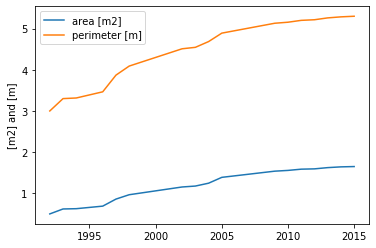

In [6]:
#now agg together for annual average area and perimeter
avg_module_area = pd.DataFrame(wtd_module_area.agg('sum', 'columns'))
avg_module_perimeter = pd.DataFrame(wtd_module_perimeter.agg('sum', 'columns'))
avg_module_area.columns = ['area']
avg_module_perimeter.columns = ['perimeter']

#print(avg_module_area)
#print(avg_module_perimeter)

plt.plot(avg_module_area, label='area [m2]')
plt.plot(avg_module_perimeter, label = 'perimeter [m]')
plt.legend()
plt.ylabel('[m2] and [m]')

These data only go through 2015, therefore we need more data for recent history. The trend in larger, higher Wp modules has continued, with the ITRPV 2020 restandardizing their average module to 1.7 m^2 in 2019, from 1.64 m^2 previously. This area will be assumed starting in 2019, and it will be assumed to be 1m x 1.7m in dimensions. These assumptions will be added to the datasets below.

In [7]:
#add years to perimeter data
#create an empty df as a place holder
yrs2 = pd.Series(index=range(2016,2025), dtype='float64')
tempdf2 = pd.DataFrame(yrs2, columns=avg_module_perimeter.columns)
avg_module_perimeter_addrange = pd.concat([avg_module_perimeter, tempdf2]) #attach it to rest of df
#print(avg_module_perimeter_addrange)

In [8]:
#calculate the perimeter in 2019 from 1.7
perimeter_2019 = 2*1+2*1.7
avg_module_perimeter_addrange.loc[2019] = perimeter_2019
avg_module_perimeter_full = avg_module_perimeter_addrange.interpolate(limit_direction='both')
#print(avg_module_perimeter_full)

In [9]:
#add years to area data
#create an empty df as a place holder
yrs3 = pd.Series(index=range(2016,2025), dtype='float64')
tempdf3 = pd.DataFrame(yrs3, columns=avg_module_area.columns)
avg_module_area_addrange = pd.concat([avg_module_area, tempdf3]) #attach it to rest of df

#now set 2019 = 1.7m^2
avg_module_area_addrange.loc[2019] = 1.7
avg_module_area_full = avg_module_area_addrange.interpolate(limit_direction='both')
#print(avg_module_area_full)

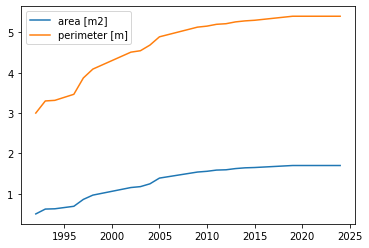

In [10]:
plt.plot(avg_module_area_full, label = 'area [m2]')
plt.plot(avg_module_perimeter_full, label='perimeter [m]')
plt.legend()

Now we have module area and perimeter through 2025, we can combine these with the density of aluminum OR mass per meter of Al. The maths to arrive at mass of Al per m2 of module will be:

    kg/meter * module perimeter (m) / module area (m2) = kg/m2 of module
    
The ITRPV has kg/m values of Al frames in the 2012 and 2013 editions, indicating an average of 0.6 kg/m in 2012. A 1995 LCA used 0.35 kg/m, and 1 to 1.4 kg of aluminum per module. And Finally, Peeters et al (from above) used 0.45 kg/m, and was published in 2017, and agrees closely with ITRPV data. It seems unlikely that the aluminum frame got thicker or heavier between 1995 and 2012, therefore, we will assume the heavier frame all the way back.

## Mass per Meter of Frame Data Munging

In [11]:
al_mass_per_m_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/al_kg_per_m.csv", 
                           index_col='Year', usecols=lambda x: x not in skipcols)
print(al_mass_per_m_raw)

      AL_kg_per_m
Year             
2012         0.60
2013         0.50
2014         0.50
2015          NaN
2016         0.40
2017         0.45
2018         0.40
2019          NaN
2020          NaN
2021         0.40
2022          NaN
2023          NaN
2024         0.30


In [12]:
#create an empty df as a place holder
yrs = pd.Series(index=range(1992,2012), dtype='float64')
tempdf = pd.DataFrame(yrs, columns=['AL_kg_per_m'])
al_kgpm_addrange = pd.concat([tempdf,al_mass_per_m_raw]) #attach it to rest of df
#print(al_kgpm_addrange)
#set the 2050 value to the same as 2030
#fulldf.loc[2050] = fulldf.loc[2030]
#interpolate for missing values
#ag_gpm2_full = fulldf.interpolate()

Knowing that the 2017 data point is from Peeters et al.2017, we observe it is slightly higher than the ITRPV projection on either side (0.45 vs 0.4). Given that the 0.45 from Peeters etal was base on manufacturers datasheets, whereas the ITRPV was a 2014 projection, we will use the 0.45 kg/m data from 2017 forward, and correct 2016 up to 0.45.

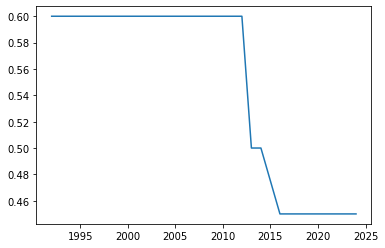

In [13]:
al_kgpm_addrange.loc[2016:] = 0.45 #set 2016 on equal to Peeters values
al_kgpm_addrange.loc[1992] = al_kgpm_addrange.loc[2012] #extend the 0.6 kg/m back through 1992
al_kgpm = al_kgpm_addrange.interpolate(limit_direction='both')
#print(al_kgpm)
plt.plot(al_kgpm)

Now multiply the perimeter of the module annually by the mass per meter annually

In [14]:
#bind mass and perimeter together for calcs
mass_perimeter = pd.concat([al_kgpm, avg_module_perimeter_full], axis=1)
mass_perimeter['mass_total_kg'] = mass_perimeter['AL_kg_per_m']*mass_perimeter['perimeter']
print(mass_perimeter)

      AL_kg_per_m  perimeter  mass_total_kg
1992        0.600      3.000        1.80000
1993        0.600      3.300        1.98000
1994        0.600      3.315        1.98900
1995        0.600      3.390        2.03400
1996        0.600      3.465        2.07900
1997        0.600      3.870        2.32200
1998        0.600      4.090        2.45400
1999        0.600      4.195        2.51700
2000        0.600      4.300        2.58000
2001        0.600      4.405        2.64300
2002        0.600      4.510        2.70600
2003        0.600      4.545        2.72700
2004        0.600      4.685        2.81100
2005        0.600      4.890        2.93400
2006        0.600      4.950        2.97000
2007        0.600      5.010        3.00600
2008        0.600      5.070        3.04200
2009        0.600      5.130        3.07800
2010        0.600      5.155        3.09300
2011        0.600      5.200        3.12000
2012        0.600      5.215        3.12900
2013        0.500      5.260    

Now we have a mass per module in kg due to the Aluminum frame. This value will now be divided by module area.

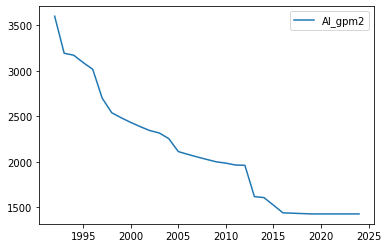

In [15]:
al_kgpm2 = pd.concat([mass_perimeter['mass_total_kg'], avg_module_area_full], axis=1)
al_kgpm2['Al_gpm2'] = al_kgpm2['mass_total_kg']/al_kgpm2['area']*1000
#print(al_kgpm2)
plt.plot(al_kgpm2['Al_gpm2'], label='Al_gpm2')
plt.legend()

## Then, weight this value by the marketshare of framed vs frameless

In addition to the average module size, there are some modules which have no frame. The ITRPVs captured this data, and it will be applied here to appropriately weight the average module having a frame or not.

In [16]:
frame_noframe_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/marketshare_frame-noframe.csv", 
                           index_col='Year', usecols=lambda x: x not in skipcols)
print(frame_noframe_raw)

      Al_framed  frameless  Plastic
Year                               
2013      100.0        0.0      0.0
2014        NaN        NaN      NaN
2015       98.0        2.0      0.0
2016       98.0        2.0      0.0
2017       96.0        3.0      1.0
2018       95.0        5.0      0.0
2019       94.0        6.0      2.0
2020       92.0        8.0      2.0
2021        NaN        NaN      NaN
2022       89.0        9.0      2.0
2023        NaN        NaN      NaN
2024       83.0       14.0      3.0
2025        NaN        NaN      NaN
2026        NaN        NaN      NaN
2027       77.0       19.0      4.0
2028        NaN        NaN      NaN
2029        NaN        NaN      NaN
2030       73.0       23.0      4.0


Prior to 2013, the ITRPV describes aluminum frames as "the norm", therefore we will assume prior to 2013 that all modules had aluminum frames. Similarly, the fraction of frameless modules continues to grow, therefore the 2020 projection out to 2030 will be used, then held constant through 2050.

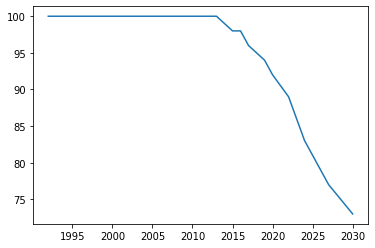

In [17]:
#Select down to only Al frame percentage
framed_perc = pd.DataFrame(frame_noframe_raw['Al_framed'])

#create an empty df as a place holder
yrs4 = pd.Series(index=range(1992,2013), dtype='float64')
tempdf4 = pd.DataFrame(yrs4, columns=['Al_framed'])
framed_fract_empty = pd.concat([tempdf4,framed_perc]) #attach it to rest of df
framed_perc_full = framed_fract_empty.interpolate(limit_direction='both')
#print(framed_perc_full)
plt.plot(framed_perc_full)

Text(0, 0.5, 'g/m2 of module')

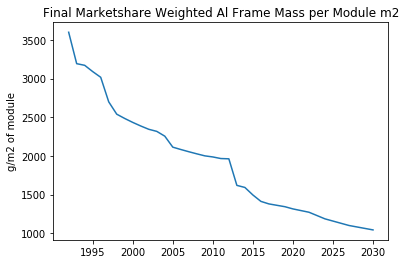

In [18]:
#Convert percentage to fraction
framed_perc = framed_perc_full/100

#bind together
al_kgpm2_mrktshr = pd.concat([framed_perc, al_kgpm2['Al_gpm2']], axis=1)
al_kgpm2_mrktshr.ffill(axis=0, inplace=True) #hold 2024 values of al g/m2 through 2030

#multiply to get 3rd column of marketshare weighted data
al_kgpm2_mrktshr['Al_wtd_gpm2'] = al_kgpm2_mrktshr['Al_framed']*al_kgpm2_mrktshr['Al_gpm2']

#print(al_kgpm2_mrktshr)
plt.plot(al_kgpm2_mrktshr['Al_wtd_gpm2'])
plt.title('Final Marketshare-Weighted Al Frame Mass per Module m2')
plt.ylabel("g/m2 of module")

In [19]:
final_al_gpm2 = pd.DataFrame(al_kgpm2_mrktshr['Al_wtd_gpm2'])
final_al_gpm2.to_csv(cwd+'/../../PV_ICE/baselines/SupportingMaterial/output_al_g_per_m2.csv', index=True)